### Check type of GPU and VRAM available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA A100-SXM4-40GB, 40960 MiB, 40536 MiB


# Clone repos we need


In [2]:
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git

Cloning into 'profaile-pic-dev'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 201 (delta 14), reused 23 (delta 8), pack-reused 168
Receiving objects: 100% (201/201), 69.51 MiB | 40.03 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [3]:
# Handle all of the dependencies
!cd /content/profaile-pic-dev/train_normal && pip install -r requirements_colab.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 890.2/890.2 MB 124.1 MB/s eta 0:00:01tcmalloc: large alloc 1112711168 bytes == 0x3ddf8000 @  0x7fc97377c680 0x7fc97379cda2 0x5f714c 0x64d800 0x527022 0x504866 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x569d8a 0x5f60c3 0x56bbe1 0x5f5ee6 0x56bbe1 0x569d8a 0x5f60c3 0x56cc92 0x569d8a 0x5f60c3 0x56bbe

### Connect to AWS
- Add your key and secret key as 
````
%%writefile ~/.passwd-s3fs
<key>:<secret_key>
````


In [4]:
%%writefile ~/.passwd-s3fs
# ADD here <key>:<secret>

Writing /root/.passwd-s3fs


In [5]:
!chmod 600 ~/.passwd-s3fs
!apt install s3fs
!mkdir /s3-user-training
!mkdir /s3-user-io
!mkdir /s3-constants
!s3fs sagemaker-user-training /s3-user-training
!s3fs sagemaker-user-io /s3-user-io
!s3fs sagemaker-constants /s3-constants

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 234 kB of archives.
After this operation, 678 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 s3fs amd64 1.86-1 [234 kB]
Fetched 234 kB in 0s (751 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 129506 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.86-1_amd64.deb ...
Unpacking s3fs (1.86-1) ...
Setting up s3fs (1.86-1) ...
Processing triggers for man-db (2.9.1-1) ...


### Specify gender and user id

In [16]:
# Store model weights here
MODEL_CHECKPOINT_DIR = "/content/model/checkpoints"
MODEL_FINAL_DIR = "/content/model/final"
INSTANCE_DATA_DIR = f"/content/data/instance_images"
CLASS_DATA_DIR = "/content/data/class_images"

import json
import os
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(CLASS_DATA_DIR, exist_ok=True)

In [21]:
USER_ID = "QMEkTX6HwnS3MZPvCxMqq5PI7w82"
import shutil
shutil.copytree(f"/s3-user-io/{USER_ID}/uploads", INSTANCE_DATA_DIR)

'/content/data/instance_images'

### Launch the training

In [ ]:
!accelerate launch /content/profaile-pic-dev/train_normal/train_colab.py \
  --pretrained_base_model_path="stabilityai/stable-diffusion-2-1-base" \
  --model_output_dir=$MODEL_FINAL_DIR \
  --model_checkpoint_dir=$MODEL_CHECKPOINT_DIR \
  --checkpointing_interval=1000 \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --instance_prompt="Picture of qonvhs, a person" \
  --class_prompt="Picture of a person" \
  --with_prior_preservation=True \
  --num_class_images=100 \
  --class_batch_size=4 \
  --seed=1337 \
  --train_text_encoder=True \
  --train_batch_size=1 \
  --max_train_steps=3500 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing=True \
  --mixed_precision="no" \
  --use_8bit_adam=True

2023-01-26 15:52:00.227087: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Caching latents: 100% 100/100 [00:10<00:00,  9.27it/s]
Steps:  29% 1000/3500 [07:44<19:11,  2.17it/s, loss=0.283, lr=1e-6]
Fetching 12 files: 100% 12/12 [00:00<00:00, 62757.67it/s]
Steps:  47% 1629/3500 [12:46<14:31,  2.15it/s, loss=0.278, lr=1e-6]

### Preview the results

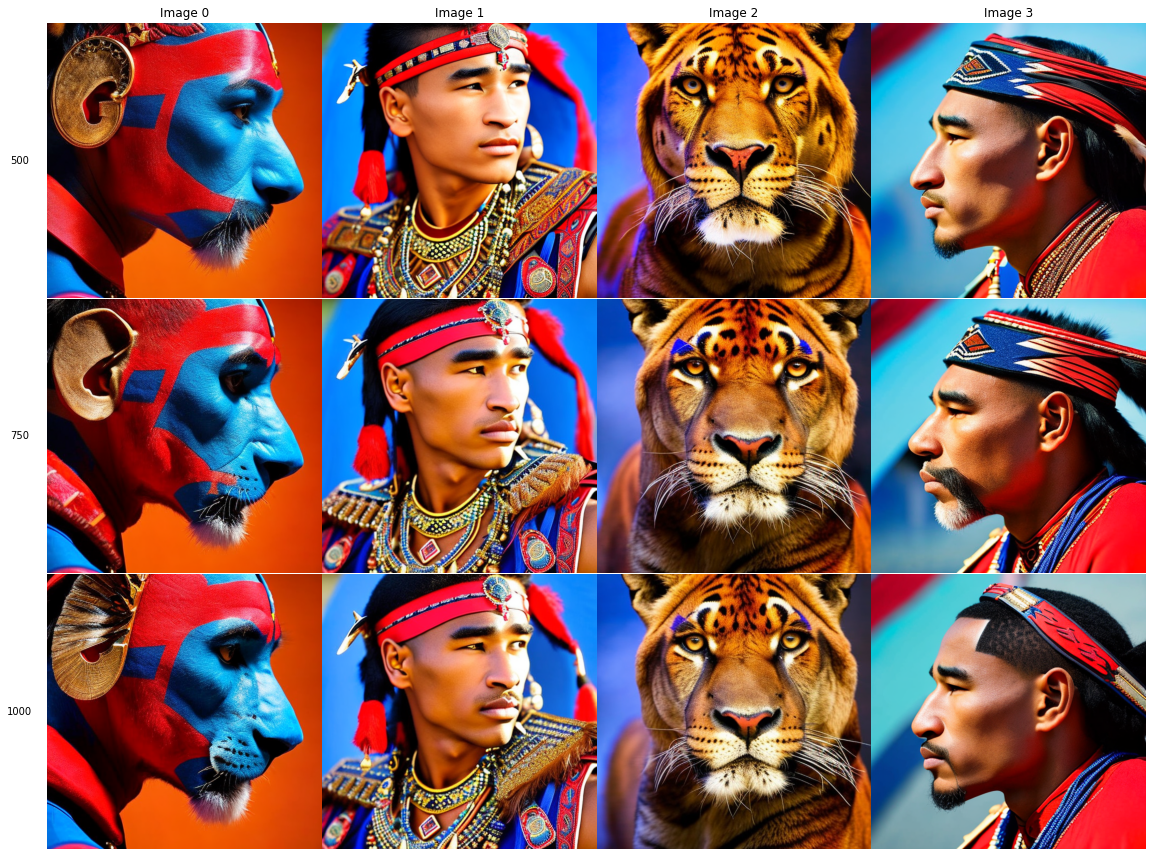

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

### Select the weights to use

In [ ]:
WEIGHTS_DIR = os.path.join(OUTPUT_DIR, "1000")
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/train/750


### Push model to Google Drive so you can use it later

- Adapt this path: PATH_TO_COPY_MODEL_TO_GDRIVE where you want to upload the trained model to

In [ ]:
import shutil
PATH_TO_COPY_MODEL_TO_GDRIVE = ""
shutil.copytree(WEIGHTS_DIR, )

## Part 2 Inference

### Util stuff

In [ ]:
# Util functions
from PIL import Image
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display

if PRECISION == "fp16":
    fp16 = True
else:
    fp16 = False

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

scheduler_euler = EulerDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
scheduler_ddim = DDIMScheduler.from_pretrained(MODEL_NAME,subfolder="scheduler")

# First for Euler
if fp16:
  pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler_euler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
else:
  pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler_euler, safety_checker=None, torch_dtype=torch.float32).to("cuda")

# Then for DDIM
g_cuda = torch.Generator(device='cuda').manual_seed(52362)

num_samples = 10
guidance_scale = 7
num_inference_steps = 70
height = 512
width = 512

### Play around with these parameters.
- Note: If you want to be in the image you have to add your abbreviation and gender into the positive promt.
- Run the next cell to generate the images.

In [ ]:
YOUR_NAME_ABBREVIATION = "mshymyr"
MAN_OR_WOMAN = "man"

  0%|          | 0/70 [00:00<?, ?it/s]

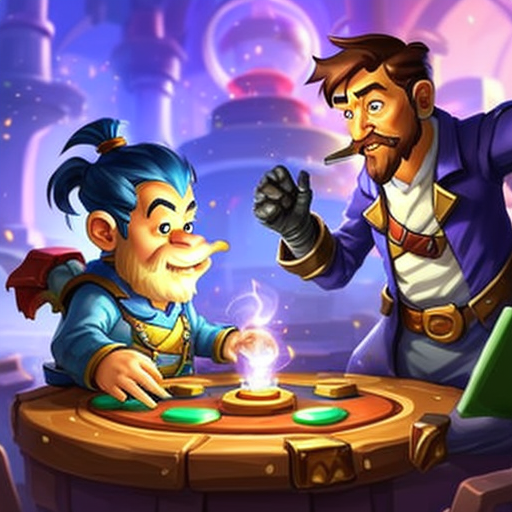

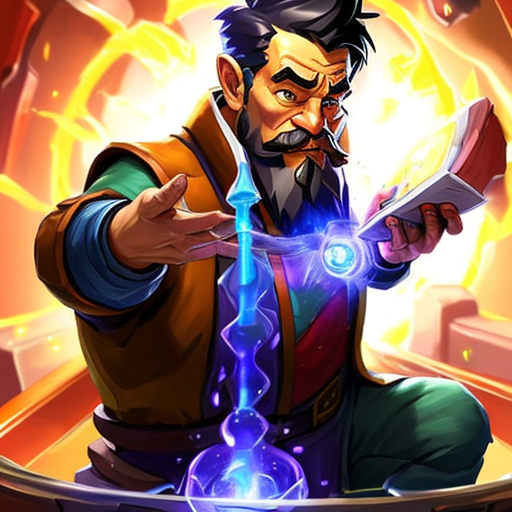

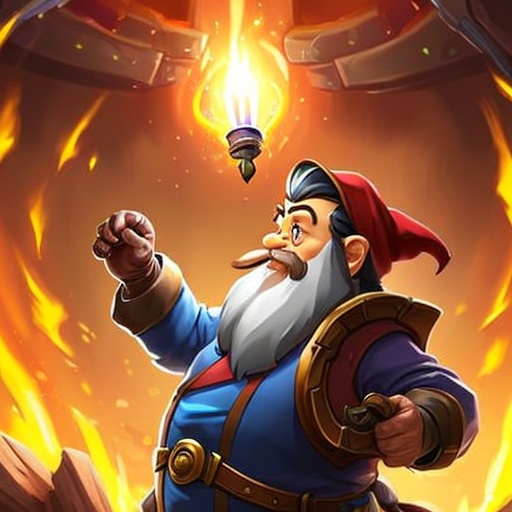

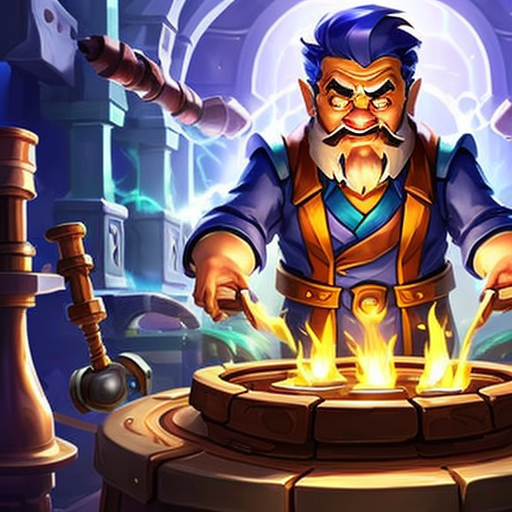

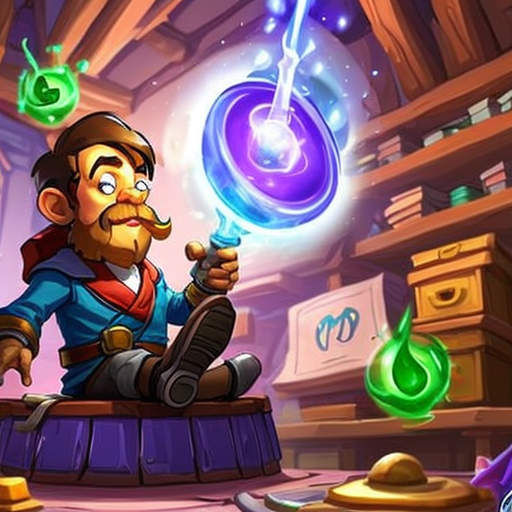

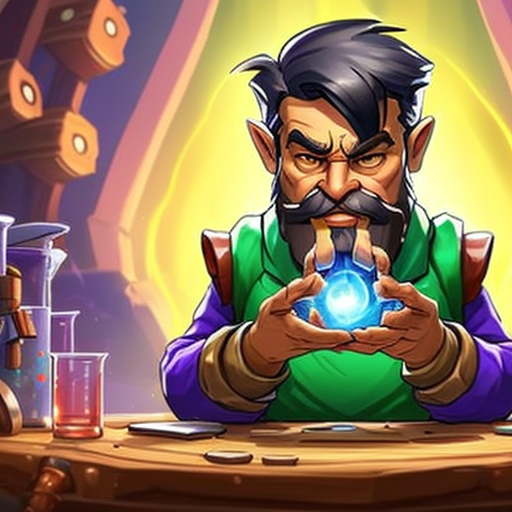

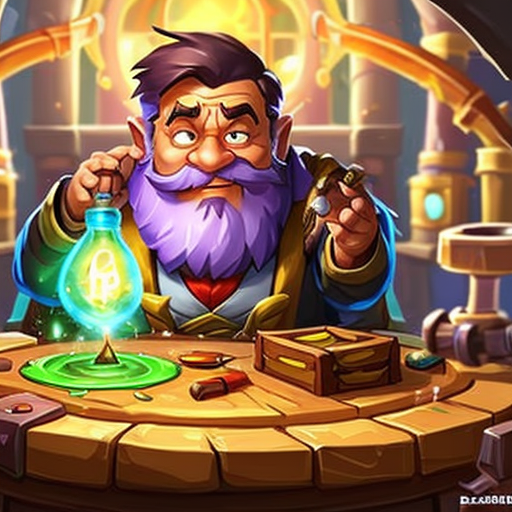

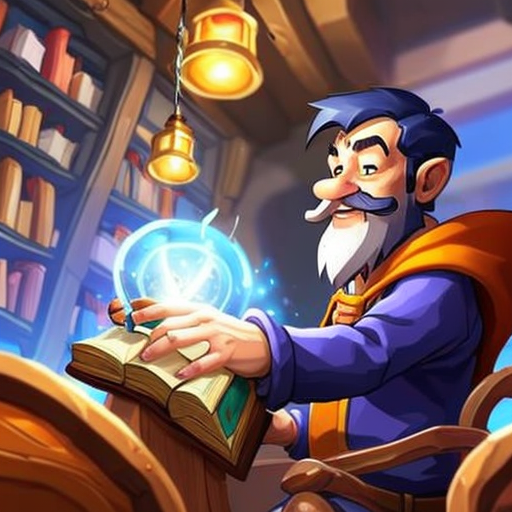

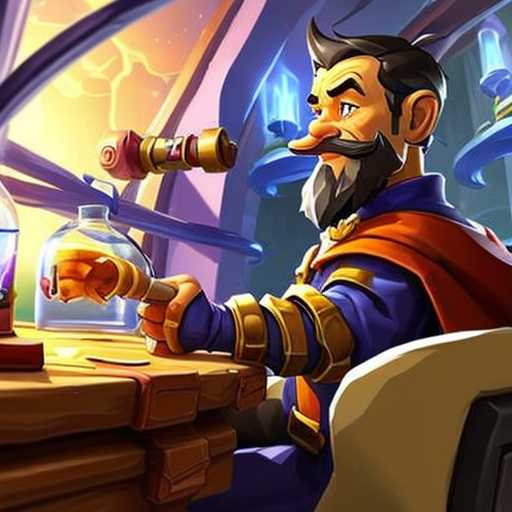

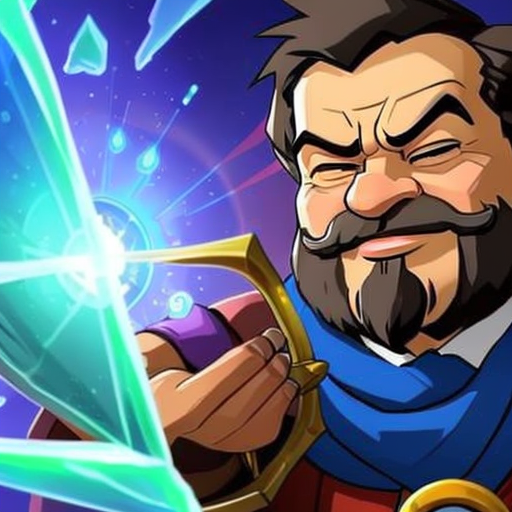

In [ ]:
# Example prompt 1
prompt = f"medium shot side profile portrait photo of the {YOUR_NAME_ABBREVIATION} {MAN_OR_WOMAN} warrior chief, tribal panther make up, blue on red, looking away, serious eyes, 50mm portrait, photography, hard rim lighting photography –ar 2:3 –beta –upbeta"
negative_prompt = "blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"

# Example prompt 2
#prompt = f"a painting of a {YOUR_NAME_ABBREVIATION} thinker no facial hair, thoughtful, focused, visionary, calm, jovial, loving, fatherly, generous, elegant well fed elder with few eyebrows and his on from Kenya by Henry Ossawa Tanner . dramatic angle, ethereal lights, details, smooth, sharp focus, illustration, realistic, cinematic, artstation, award winning, rgb , unreal engine, octane render, cinematic light, macro, depth of field, blur, red light and clouds from the back, highly detailed epic cinematic concept art CG render made in Maya, Blender and Photoshop, octane render, excellent composition, dynamic dramatic cinematic lighting, aesthetic, very inspirational, arthouse"
#negative_prompt = "colourful 3d crystals and gems, vintage 1950s stamp, full color manga cover, kewpie, two girls, anime, fairytale illustration, chinese ribbon dance, children illustration, flower dress, illustration, silk shoes, classic children's illustrations, adorable and whimsical "

# Example prompt 3
#prompt = f"comic book cover, {YOUR_NAME_ABBREVIATION}{MAN_OR_WOMAN} in the city, reddit, antipodeans, leading lines, preparing to fight, trending on imagestation, son, full device, some orange and blue, rear facing, netting, marvel, serious business, centered composition, wide shot "
#negative_prompt = "egyptian landscape, black and white old photo, black t - shirt"

# Example prompt 4
#prompt = f"mad (({YOUR_NAME_ABBREVIATION})) dwarf scientist working on the lab, alchemist, concept art, hearthstone official splash art, oceanside, full-shot, highres, hd wallpaper, album, despicable, legends, card game illustration, centered composition"
#negative_prompt = "troops searching the area, from police academy 2 (1985), gunma prefecture, concrete housing, nsfw, blur, wood block print, in africa, kodak tri - x 3 5 mm, black lace, american flag, football players, tokyo japan, ferrari 458, woodblock print"

# More prompts: Check out this great resource
# https://stability.ai/sdv2-prompt-book


images = pipe(
    prompt,
    height=height,
    width=width,
    negative_prompt=negative_prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=g_cuda
).images
for image in images:
  display(image)